In [1]:
import cgpm.utils.general as general
import json
import itertools
import pandas as pd
import yaml
import numpy as np
import copy
from cgpm.crosscat.state import State
from cgpm.mixtures.dim import Dim

In [2]:
from dataclasses import dataclass
from typing import Mapping

In [3]:
import matplotlib.pyplot as plt
import scipy

In [4]:
sample_file_idx = 2
with open(f'../data/cgpm/complete/sample.{sample_file_idx}.json') as unrefined_metadata_file:
    unrefined_metadata = json.load(unrefined_metadata_file)

with open('../data/numericalized.csv') as data_file:
    df = pd.read_csv(data_file)

In [5]:
columns_transition = [i for i in range(df.shape[1])]

In [6]:
none_to_nan = lambda x: float('nan') if x is None else x
list_fmap = lambda f: lambda xs: list(map(f, xs))

In [7]:
lift_to_ndarray = lambda l: np.array(l) if isinstance(l, list) else l

def refine_crp_hyper_grid(state, grid=None):
    if grid is None:
        final_hyper = state.crp.hypers['alpha']
        grid = np.linspace(0.80 * final_hyper, 1.2 * final_hyper, 30)
    state.crp.hyper_grids['alpha'] = lift_to_ndarray(grid)

def refine_view_hyper_grid(state, view_idx, grid=None):
    if grid is None:
        final_hyper = state.views[view_idx].crp.hypers['alpha']
        grid = np.linspace(0.80 * final_hyper, 1.2 * final_hyper, 30)
    state.views[view_idx].crp.hyper_grids['alpha'] = lift_to_ndarray(grid)

def refine_dim_hyper_grid(state, col_idx, hyper, grid=None):
    if grid is None:
        final_hyper = state.dim_for(col_idx).hypers[hyper]
        grid = np.linspace(0.80 * final_hyper, 1.2 * final_hyper, 30)
    state.dim_for(col_idx).hyper_grids[hyper] = lift_to_ndarray(grid)

def refine_dim_hyper_grids(state, col_idx, grids=None):
    for hyper in state.dim_for(col_idx).hypers.keys():
        grid = grids[hyper] if grids is not None else None
        refine_dim_hyper_grid(state, col_idx, hyper, grid)

In [8]:
def get_dim_hyper_transition_distr(dim, hyper):
    dim = copy.deepcopy(dim)
    logps = []
    for grid_value in dim.hyper_grids[hyper]:
        # Compute the probability of the grid point.
        dim.hypers[hyper] = grid_value
        logp_k = 0
        for k in dim.clusters:
            dim.clusters[k].set_hypers(dim.hypers)
            logp_k += dim.clusters[k].logpdf_score()
        logps.append(logp_k)
    return np.exp(np.array(logps) - scipy.special.logsumexp(logps))

In [9]:
unrefined_metadata['X'] = list_fmap(list_fmap(none_to_nan))(unrefined_metadata['X'])

In [10]:
unrefined_model = State.from_metadata(unrefined_metadata)
refinement_candidate = copy.deepcopy(unrefined_model)

## CRP Hypers

In [11]:
unrefined_model.crp.hyper_grids['alpha']

array([0.125     , 0.14427533, 0.16652297, 0.19220125, 0.2218392 ,
       0.25604739, 0.29553058, 0.34110218, 0.39370104, 0.45441078,
       0.52448213, 0.60535866, 0.69870657, 0.80644898, 0.93080555,
       1.07433824, 1.24000405, 1.43121596, 1.65191326, 1.90664266,
       2.20065202, 2.5399984 , 2.93167289, 3.38374462, 3.90552702,
       4.50776964, 5.20287968, 6.00517753, 6.93119183, 8.        ])

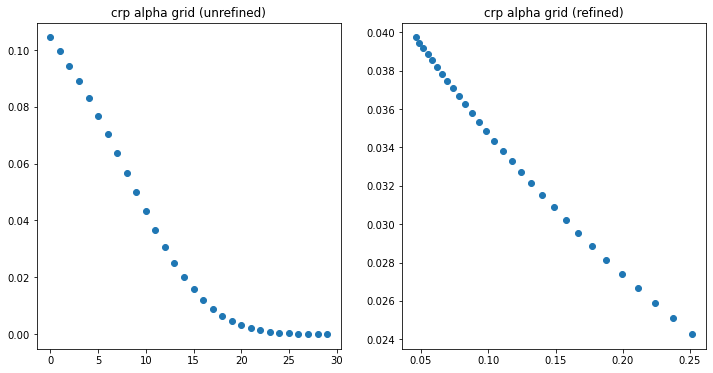

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6));
axs[0].set_title(f'crp alpha grid (unrefined)')
axs[0].scatter(range(len(unrefined_model.crp.hyper_grids['alpha'])),
               get_dim_hyper_transition_distr(unrefined_model.crp, 'alpha'))
best_alpha = unrefined_model.crp.hyper_grids['alpha'][0] # set by hand
crp_refinement_grid = np.exp(np.linspace(np.log(best_alpha)-1, np.log(best_alpha)+0.7, 30))
refine_crp_hyper_grid(refinement_candidate, crp_refinement_grid)
axs[1].set_title(f'crp alpha grid (refined)')
axs[1].scatter(refinement_candidate.crp.hyper_grids['alpha'],
               get_dim_hyper_transition_distr(refinement_candidate.crp, 'alpha'))

In [14]:
crp_refinement_grid = unrefined_model.crp.hyper_grids['alpha']

## Dim Hypers

In [15]:
dim_refinement_grids = {col: {} for col in unrefined_model.outputs}

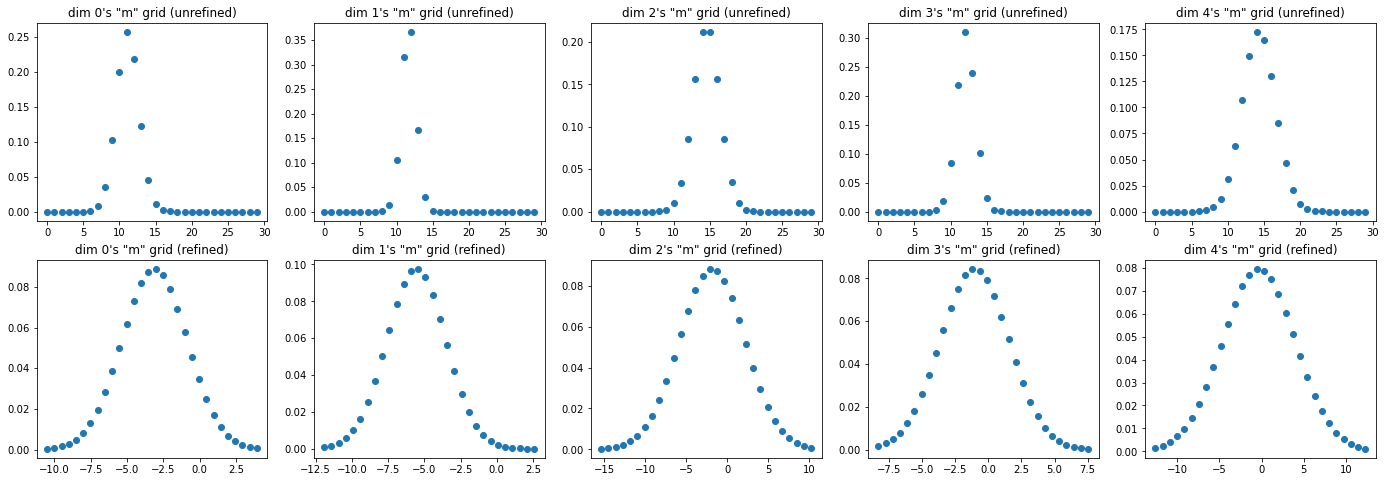

In [32]:
fig, axs = plt.subplots(2, 5, figsize=(24, 8));
get_m = lambda col, i: unrefined_model.dim_for(col).hyper_grids['m'][i]

# set by hand
dim_refinement_grids[0]['m'] = np.linspace(get_m(0, 6) * 1.00, get_m(0, 16) * 1.00, 30)
dim_refinement_grids[1]['m'] = np.linspace(get_m(1, 9) * 1.10, get_m(1, 16) * 0.85, 30)
dim_refinement_grids[2]['m'] = np.linspace(get_m(2, 8) * 0.95, get_m(2, 20) * 1.00, 30)
dim_refinement_grids[3]['m'] = np.linspace(get_m(3, 9) * 1.15, get_m(3, 17) * 0.85, 30)
dim_refinement_grids[4]['m'] = np.linspace(get_m(4, 7) * 0.90, get_m(4, 21) * 1.00, 30)

for i in columns_transition[:-3]:
    axs[0, i].set_title(f'dim {i}\'s "m" grid (unrefined)')
    axs[0, i].scatter(range(len(unrefined_model.dim_for(i).hyper_grids['m'])),
                      get_dim_hyper_transition_distr(unrefined_model.dim_for(i), 'm'))
    refine_dim_hyper_grid(refinement_candidate, i, 'm', dim_refinement_grids[i]['m'])
    axs[1, i].set_title(f'dim {i}\'s "m" grid (refined)')
    axs[1, i].scatter(refinement_candidate.dim_for(i).hyper_grids['m'],
                      get_dim_hyper_transition_distr(refinement_candidate.dim_for(i), 'm'))

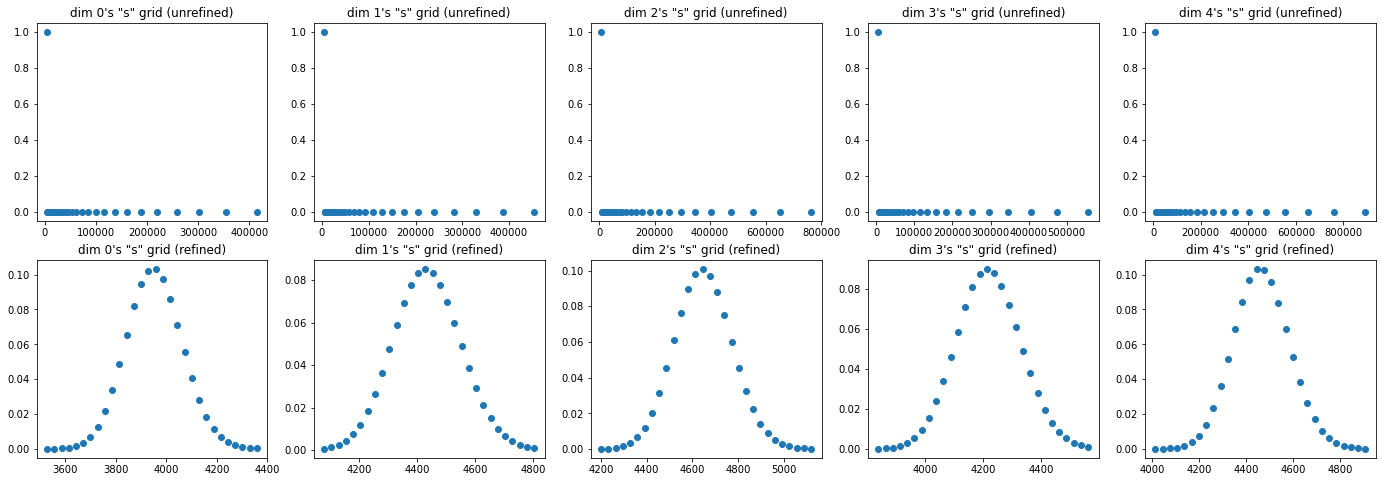

In [77]:
fig, axs = plt.subplots(2, 5, figsize=(24, 8));
get_s = lambda col, i: unrefined_model.dim_for(col).hyper_grids['s'][i]

# set by hand
dim_refinement_grids[0]['s'] = np.linspace(get_s(0, 0) * 0.85, get_s(0, 0) * 1.05, 30)
dim_refinement_grids[1]['s'] = np.linspace(get_s(1, 0) * 0.90, get_s(1, 0) * 1.06, 30)
dim_refinement_grids[2]['s'] = np.linspace(get_s(2, 0) * 0.55, get_s(2, 0) * 0.67, 30)
dim_refinement_grids[3]['s'] = np.linspace(get_s(3, 0) * 0.69, get_s(3, 0) * 0.82, 30)
dim_refinement_grids[4]['s'] = np.linspace(get_s(4, 0) * 0.45, get_s(4, 0) * 0.55, 30)

for i in columns_transition[:-3]:
    axs[0, i].set_title(f'dim {i}\'s "s" grid (unrefined)')
    axs[0, i].scatter(unrefined_model.dim_for(i).hyper_grids['s'],
                      get_dim_hyper_transition_distr(unrefined_model.dim_for(i), 's'))
    refine_dim_hyper_grid(refinement_candidate, i, 's', dim_refinement_grids[i]['s'])
    axs[1, i].set_title(f'dim {i}\'s "s" grid (refined)')
    axs[1, i].scatter(refinement_candidate.dim_for(i).hyper_grids['s'],
                      get_dim_hyper_transition_distr(refinement_candidate.dim_for(i), 's'))

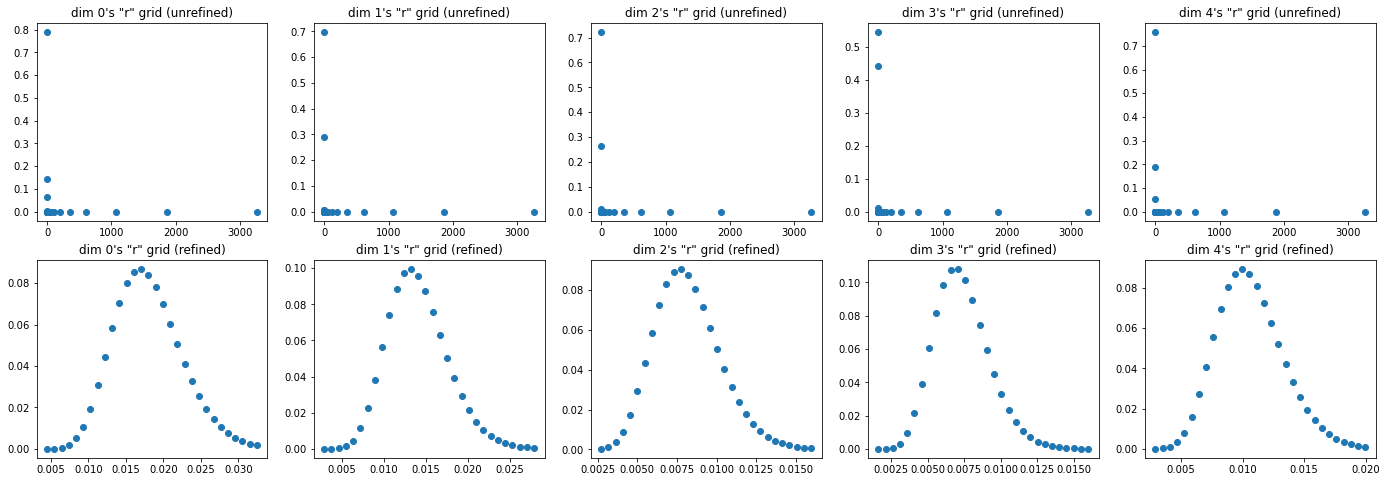

In [89]:
fig, axs = plt.subplots(2, 5, figsize=(24, 8));
get_r = lambda col, i: unrefined_model.dim_for(col).hyper_grids['r'][i]

# set by hand
dim_refinement_grids[0]['r'] = np.linspace(get_r(0, 5) * 0.90, get_r(0, 10) * 0.40, 30)
dim_refinement_grids[1]['r'] = np.linspace(get_r(1, 4) * 1.00, get_r(1, 9) * 0.60, 30)
dim_refinement_grids[2]['r'] = np.linspace(get_r(2, 4) * 0.95, get_r(2, 8) * 0.60, 30)
dim_refinement_grids[3]['r'] = np.linspace(get_r(3, 3) * 1.00, get_r(3, 8) * 0.60, 30)
dim_refinement_grids[4]['r'] = np.linspace(get_r(4, 4) * 1.02, get_r(4, 8) * 0.75, 30)

for i in columns_transition[:-3]:
    axs[0, i].set_title(f'dim {i}\'s "r" grid (unrefined)')
    axs[0, i].scatter(unrefined_model.dim_for(i).hyper_grids['r'],
                      get_dim_hyper_transition_distr(unrefined_model.dim_for(i), 'r'))
    refine_dim_hyper_grid(refinement_candidate, i, 'r', dim_refinement_grids[i]['r'])
    axs[1, i].set_title(f'dim {i}\'s "r" grid (refined)')
    axs[1, i].scatter(refinement_candidate.dim_for(i).hyper_grids['r'],
                      get_dim_hyper_transition_distr(refinement_candidate.dim_for(i), 'r'))

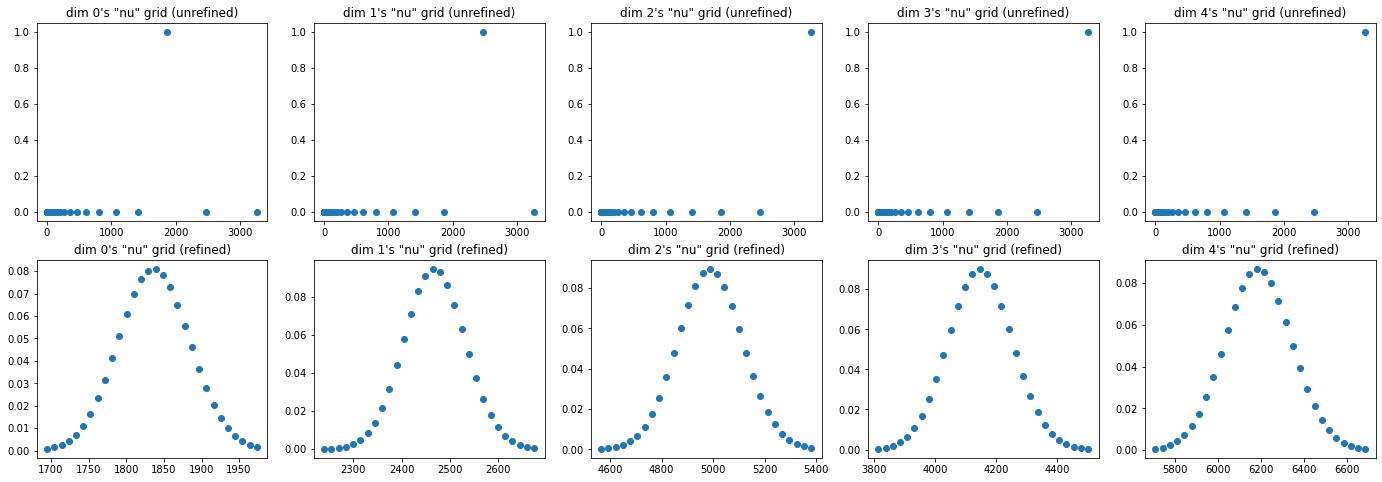

In [123]:
fig, axs = plt.subplots(2, 5, figsize=(24, 8));
get_nu = lambda col, i: unrefined_model.dim_for(col).hyper_grids['nu'][i]

# set by hand
dim_refinement_grids[0]['nu'] = np.linspace(get_nu(0, -4) * 1.20, get_nu(0, -2) * 0.80, 30)
dim_refinement_grids[1]['nu'] = np.linspace(get_nu(1, -3) * 1.20, get_nu(1, -1) * 0.82, 30)
dim_refinement_grids[2]['nu'] = np.linspace(get_nu(2, -1) * 1.40, get_nu(2, -1) * 1.65, 30)
dim_refinement_grids[3]['nu'] = np.linspace(get_nu(3, -1) * 1.17, get_nu(3, -1) * 1.38, 30)
dim_refinement_grids[4]['nu'] = np.linspace(get_nu(4, -1) * 1.75, get_nu(4, -1) * 2.05, 30)

for i in columns_transition[:-3]:
    axs[0, i].set_title(f'dim {i}\'s "nu" grid (unrefined)')
    axs[0, i].scatter(unrefined_model.dim_for(i).hyper_grids['nu'],
                      get_dim_hyper_transition_distr(unrefined_model.dim_for(i), 'nu'))
    refine_dim_hyper_grid(refinement_candidate, i, 'nu', dim_refinement_grids[i]['nu'])
    axs[1, i].set_title(f'dim {i}\'s "nu" grid (refined)')
    axs[1, i].scatter(refinement_candidate.dim_for(i).hyper_grids['nu'],
                      get_dim_hyper_transition_distr(refinement_candidate.dim_for(i), 'nu'))

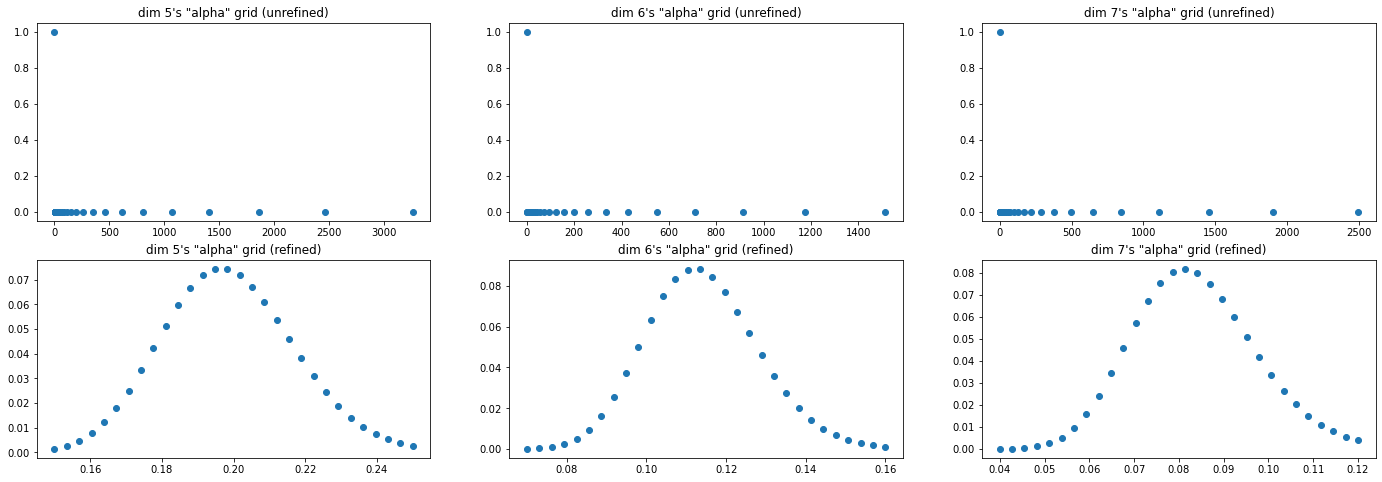

In [133]:
fig, axs = plt.subplots(2, 3, figsize=(24, 8));
get_alpha = lambda col, i: unrefined_model.dim_for(col).hyper_grids['alpha'][i]

# set by hand
dim_refinement_grids[5]['alpha'] = np.linspace(get_alpha(5, 0) * 0.15, get_alpha(5, 0) * 0.25, 30)
dim_refinement_grids[6]['alpha'] = np.linspace(get_alpha(6, 0) * 0.07, get_alpha(6, 0) * 0.16, 30)
dim_refinement_grids[7]['alpha'] = np.linspace(get_alpha(7, 0) * 0.04, get_alpha(7, 0) * 0.12, 30)

for i in columns_transition[-3:]:
    axs[0, i-5].set_title(f'dim {i}\'s "alpha" grid (unrefined)')
    axs[0, i-5].scatter(unrefined_model.dim_for(i).hyper_grids['alpha'],
                        get_dim_hyper_transition_distr(unrefined_model.dim_for(i), 'alpha'))
    refine_dim_hyper_grid(refinement_candidate, i, 'alpha', dim_refinement_grids[i]['alpha'])
    axs[1, i-5].set_title(f'dim {i}\'s "alpha" grid (refined)')
    axs[1, i-5].scatter(refinement_candidate.dim_for(i).hyper_grids['alpha'],
                        get_dim_hyper_transition_distr(refinement_candidate.dim_for(i), 'alpha'))

## View Hypers

In [134]:
view_refinement_grids = {}

In [135]:
unrefined_model.views

OrderedDict([(0, <cgpm.mixtures.view.View at 0x7fff3f918100>)])

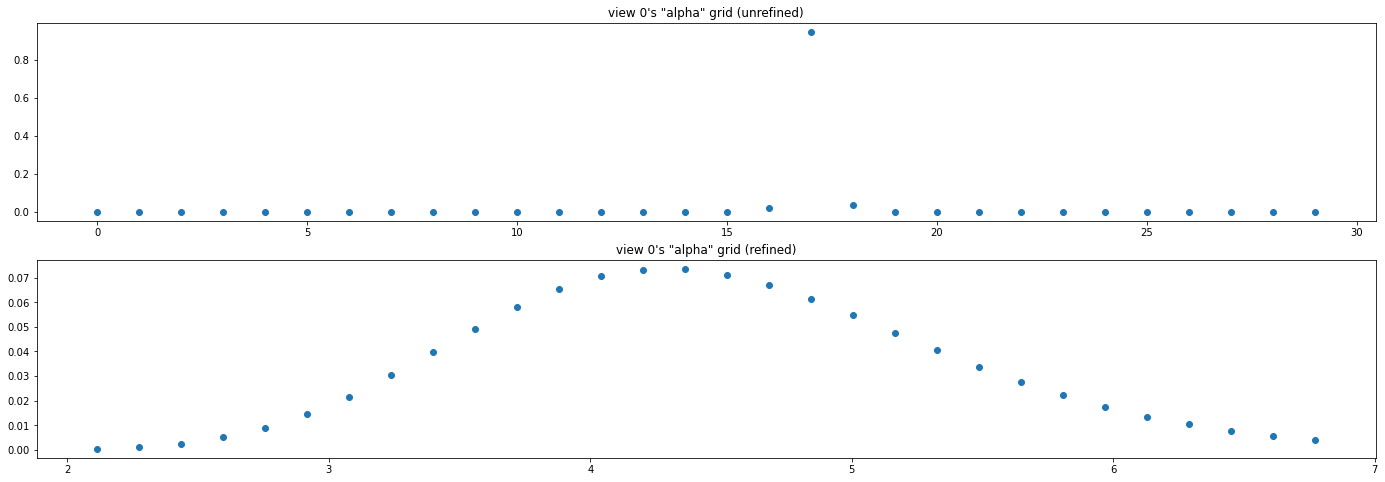

In [148]:
fig, axs = plt.subplots(2, len(unrefined_model.views), figsize=(24, 8));
get_view_alpha = lambda view, i: unrefined_model.views[view].crp.hyper_grids['alpha'][i]

#set by hand
view_refinement_grids[0] = np.linspace(get_view_alpha(0, 15) * 1.60, get_view_alpha(0, 19) * 0.55, 30)
#view_refinement_grids[4] = np.linspace(get_view_alpha(0, 10) * 1.00, get_view_alpha(0, 17) * 0.41, 30)

for (i, view_idx) in enumerate(unrefined_model.views.keys()):
    axs[0].set_title(f'view {view_idx}\'s "alpha" grid (unrefined)')
    axs[0].scatter(range(len(unrefined_model.views[view_idx].crp.hyper_grids['alpha'])),
                   get_dim_hyper_transition_distr(unrefined_model.views[view_idx].crp, 'alpha'))
    refine_view_hyper_grid(refinement_candidate, view_idx, view_refinement_grids[view_idx])
    axs[1].set_title(f'view {view_idx}\'s "alpha" grid (refined)')
    axs[1].scatter(refinement_candidate.views[view_idx].crp.hyper_grids['alpha'],
                      get_dim_hyper_transition_distr(refinement_candidate.views[view_idx].crp, 'alpha'))

## Serialization

In [149]:
refinement_grids = {
    'crp': crp_refinement_grid,
    'dim': dim_refinement_grids,
    'view': view_refinement_grids
}

In [150]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return list(obj)
        return json.JSONEncoder.default(obj)

In [151]:
with open(f'../data/cgpm/refined-grids/sample.{sample_file_idx}.json', 'w+') as refined_grid_file:
    json.dump(refinement_grids, refined_grid_file, cls=MyEncoder)